In [2]:
%load_ext autoreload
%autoreload 2
import innvestigate
import tensorflow as tf
from pathlib import Path
import xarray as xr
from shared.training import split_data_on_participants, train_and_evaluate
from shared.normalization import *
from shared.generators import SAT1DataGenerator
import matplotlib.pyplot as plt
import numpy as np
from shared.data import SAT1_STAGES_ACCURACY, preprocess

tf.compat.v1.disable_eager_execution()
from mne.viz import plot_topomap
from mne.io import read_info
from collections import defaultdict
%env TF_FORCE_GPU_ALLOW_GROWTH=true
%env TF_GPU_ALLOCATOR=cuda_malloc_async

2023-10-10 12:06:46.323353: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 12:06:46.843872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TF_GPU_ALLOCATOR=cuda_malloc_async


In [39]:
data_path = Path("data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

train_data, val_data, test_data = split_data_on_participants(data, 60, norm_dummy)

In [40]:
positions = read_info(Path("data/sat1/preprocessed/processed_0001_epo.fif"))

In [41]:
model = tf.keras.models.load_model("models/cnn_base_new")


def model_modifier(model):
    model.layers[-1].activation = tf.keras.activations.linear


model_modifier(model)
analyzer = innvestigate.create_analyzer(
    "lrp.sequential_preset_a_flat", model, epsilon=1
)

2023-10-10 12:29:09.714009: W tensorflow/c/c_api.cc:304] Operation '{name:'AssignVariableOp_40' id:1022 op device:{requested: '/device:CPU:0', assigned: ''} def:{{{node AssignVariableOp_40}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false, _device="/device:CPU:0"](total_4, Identity_40)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [42]:
test_set = preprocess(test_data)
# Add data variable consisting of zeroes
test_set = test_set.assign(
    analysis=(("index", "samples", "channels"), np.zeros_like(test_set.data))
)

test_gen = SAT1DataGenerator(test_set, do_preprocessing=False)
for i, batch in enumerate(test_gen):
    batch_analysis = analyzer.analyze(np.expand_dims(batch[0].data, axis=3))
    test_set.analysis[i * len(batch[1]) : (i + 1) * len(batch[1]), :, :] = np.squeeze(
        batch_analysis
    )

2023-10-10 12:29:13.555915: W tensorflow/c/c_api.cc:304] Operation '{name:'kernel_22/Assign' id:1385 op device:{requested: '', assigned: ''} def:{{{node kernel_22/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_22, kernel_22/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-10-10 12:29:13.816939: W tensorflow/c/c_api.cc:304] Operation '{name:'gradients_15/MaxNeuronSelection_1/Max_grad/range' id:1457 op device:{requested: '', assigned: ''} def:{{{node gradients_15/MaxNeuronSelection_1/Max_grad/range}} = Range[Tidx=DT_INT32, _class=["loc:@MaxNeuronSelection_1/Max"], _has_manual_control_dependencies=true](gradients_15/MaxNeuronSelection_1/Max_grad/range/start, gradients_15/MaxNeuronSelection_1/Max_grad/Size, gradients_15/Ma

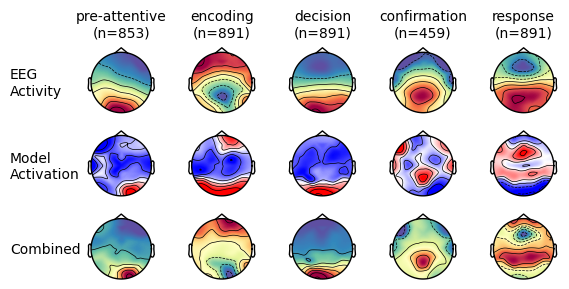

In [44]:
f, ax = plt.subplots(nrows=3, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 3))

for i, label in enumerate(SAT1_STAGES_ACCURACY):
    # Get subset for label
    subset = test_set.sel(labels=label)
    n = len(subset.index)
    # Get maximum activation averaged over channels
    # TODO: Mean channels or sum channels? Maybe something else, highest n values?
    max_activation = subset.mean("channels").argmax("samples").analysis
    max_samples = subset.sel(samples=max_activation)
    mean_max_samples = max_samples.mean("index")

    ax[0, i].set_title(f"{label}\n(n={n})", fontsize=10)
    # Row titles
    if i == 0:
        ax[0, i].text(-0.35, 0, "EEG\nActivity", va="center", ha="left")
        ax[1, i].text(-0.35, 0, "Model\nActivation", va="center", ha="left")
        ax[2, i].text(-0.35, 0, "Combined", va="center", ha="left")

    # Raw EEG Activation
    plot_topomap(
        mean_max_samples.data,
        positions,
        axes=ax[0, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_max_samples.data), np.max(mean_max_samples.data)),
        sensors=False,
        contours=6,
    )

    # Model activity
    plot_topomap(
        mean_max_samples.analysis,
        positions,
        axes=ax[1, i],
        show=False,
        cmap="bwr",
        vlim=(np.min(mean_max_samples.analysis), np.max(mean_max_samples.analysis)),
        sensors=False,
        contours=6,
    )

    # Combined
    combined = mean_max_samples.data * mean_max_samples.analysis
    plot_topomap(
        combined,
        positions,
        axes=ax[2, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(combined), np.max(combined)),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

In [7]:
# Show mean activation on y-axis, samples/time on x, at intervals (10 samples?) 10% of squished sample size?

In [9]:
test_gen = SAT1DataGenerator(test_data)
test_batch = test_gen.__getitem__(0)
# 3 is encoding, 8 is encoding
test_item = test_batch[0][0]
print(test_item)

<xarray.DataArray 'data' (samples: 154, channels: 30)>
array([[-1.22915792e+01, -1.72746162e+01, -1.25034361e+01, ...,
         1.40857115e+01,  1.11860876e+01, -2.18632445e-01],
       [-1.63107796e+01, -2.28622246e+01, -1.52661533e+01, ...,
         1.84951839e+01,  1.77053204e+01,  3.97869158e+00],
       [-1.77319412e+01, -1.98306026e+01, -1.34106379e+01, ...,
         1.97935162e+01,  1.97225132e+01,  4.34355211e+00],
       ...,
       [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02],
       [ 9.99000000e+02,  9.99000000e+02,  9.99000000e+02, ...,
         9.99000000e+02,  9.99000000e+02,  9.99000000e+02]])
Coordinates:
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 147 148 149 150 151 152 153
    stim      

In [10]:
test_item = test_item.data.reshape((1, 154, 30, 1))
analyzer = innvestigate.create_analyzer(
    "lrp.sequential_preset_a_flat", model, epsilon=1
)

In [69]:
test_data = test_batch[0].data.reshape(16, 154, 30, 1)
analysis = analyzer.analyze(test_data)
# analysis /= np.max(np.abs(analysis))
analysis = np.squeeze(analysis)

In [144]:
subset = data.where(data.labels == "response", drop=True)
subset_gen = SAT1DataGenerator(subset)

In [145]:
subset_batch = np.expand_dims(subset_gen.__getitem__(0)[0].data, axis=3)
analysis = analyzer.analyze(subset_batch)
analysis = np.squeeze(analysis)
mean_analysis = np.mean(analysis, axis=2)

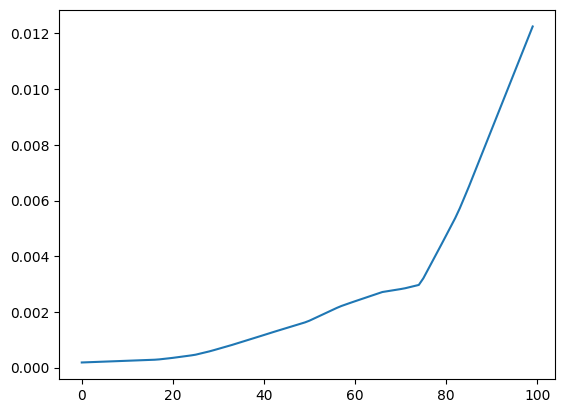

In [146]:
# Create list of different lengths ndarrays showing activation values over time
sequences = []
for sample in mean_analysis:
    zero_idx = np.where(sample == 0)[0][0]
    sequences.append(sample[0:zero_idx])

time_points = np.linspace(0, 100, 100)
interpolated = []

for seq in sequences:
    original_time_points = np.linspace(0, 100, num=len(seq))
    interpolated_sequence = np.interp(time_points, original_time_points, seq)
    interpolated.append(interpolated_sequence)
plt.plot(np.mean(interpolated, axis=0))
plt.show()

### Deprecated

In [ ]:
test_gen = SAT1DataGenerator(test_data)
test_items = defaultdict(list)
results = defaultdict(list)
results_combined = defaultdict(list)
for batch_idx in range(len(test_gen)):
    test_batch = test_gen.__getitem__(batch_idx)
    for item in test_batch[0]:
        # (154, 30) test sample
        item_label = item.labels.item()
        item_reshaped = item.data.reshape((1, 154, 30, 1))
        # Back to (154, 30)
        analysis = np.squeeze(analyzer.analyze(item_reshaped))
        # analysis /= np.max(np.abs(analysis))
        # Get max activation sample
        max_sample_idx = np.argmax(np.sum(analysis, axis=1))
        max_activation_sample = analysis[max_sample_idx, :]
        max_activity = max_activation_sample * item[max_sample_idx, :]
        test_items[item_label].append(item[max_sample_idx, :])
        results[item_label].append(max_activation_sample)
        results_combined[item_label].append(max_activity)
        # Get mean activation
        # analysis[analysis == 0] = np.nan
        # item.data[item.data == 999] = np.nan
        # mean_activation = np.nanmean(analysis, axis=0)
        # mean_activity = np.nanmean(item.data, axis=0)
        # results[item_label].append(mean_activation)
        # test_items[item_label].append(mean_activity)
        # results_combined[item_label].append(mean_activation * mean_activity)

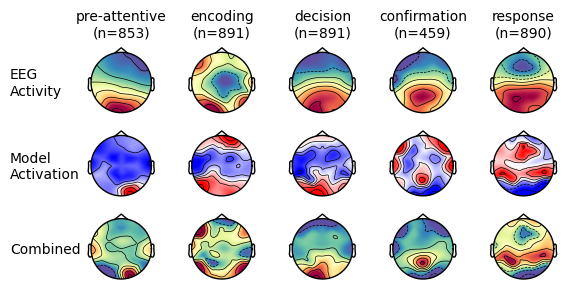

In [6]:
f, ax = plt.subplots(nrows=3, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 3))

for i, label in enumerate(SAT1_STAGES_ACCURACY):
    label_results = np.array(test_items[label])
    n = len(test_items[label])
    mean_eeg_activity = np.mean(label_results, axis=0)
    ax[0, i].set_title(f"{label}\n(n={n})", fontsize=10)

    # Row titles
    if i == 0:
        ax[0, i].text(-0.35, 0, "EEG\nActivity", va="center", ha="left")
        ax[1, i].text(-0.35, 0, "Model\nActivation", va="center", ha="left")
        ax[2, i].text(-0.35, 0, "Combined", va="center", ha="left")
    # Raw EEG Activation
    plot_topomap(
        mean_eeg_activity,
        positions,
        axes=ax[0, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_eeg_activity), np.max(mean_eeg_activity)),
        sensors=False,
        contours=6,
    )
    # Model activity
    label_results = np.array(results[label])
    mean_importance = np.mean(label_results, axis=0)
    plot_topomap(
        mean_importance,
        positions,
        axes=ax[1, i],
        show=False,
        cmap="bwr",
        vlim=(np.min(mean_importance), np.max(mean_importance)),
        sensors=False,
        contours=6,
    )
    # Combined
    label_results = np.array(results_combined[label])
    mean_combined_importance = np.mean(label_results, axis=0)
    plot_topomap(
        mean_combined_importance,
        positions,
        axes=ax[2, i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_combined_importance), np.max(mean_combined_importance)),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

In [1]:
f, ax = plt.subplots(nrows=1, ncols=len(SAT1_STAGES_ACCURACY), figsize=(6, 4))
mean_importances = np.zeros((len(SAT1_STAGES_ACCURACY), len(data.channels)))
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    # print(k)
    label_results = np.array(results[label])
    print(label_results.shape)
    mean_importance = np.mean(label_results, axis=0)
    mean_importances[i, :] = mean_importance
    # ax[i].set_title(label)
    # plot_topomap(
    #     mean_importance,
    #     positions,
    #     axes=ax[i],
    #     show=False,
    #     cmap="Spectral_r",
    #     vlim=(np.min(mean_importance), np.max(mean_importance)),
    #     sensors=False,
    #     contours=6,
    # )
# Normalized by stage
mean_importances = (mean_importances - np.mean(mean_importances, axis=0)) / np.std(
    mean_importances, axis=0
)
for i, label in enumerate(SAT1_STAGES_ACCURACY):
    ax[i].set_title(label)
    plot_topomap(
        mean_importances[i, :],
        positions,
        axes=ax[i],
        show=False,
        cmap="Spectral_r",
        vlim=(np.min(mean_importances[i, :]), np.max(mean_importances[i, :])),
        sensors=False,
        contours=6,
    )
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined